In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import string
import re
import random
import pickle
import nltk
from nltk.stem.snowball import FrenchStemmer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import SGD

import warnings
warnings.filterwarnings("ignore")

In [2]:
stemmer = FrenchStemmer()

with open('data/intents.json', encoding = 'utf-8') as file :
    data = json.load(file)

words = []
classes = []
documents = []
for intent in data['intents'] :
    for pattern in intent['patterns'] :
        word_list = nltk.word_tokenize(pattern)
        words.extend(word_list)

        documents.append((word_list, intent['tag']))

        if intent['tag'] not in classes :
            classes.append(intent['tag'])

words = [stemmer.stem(word.lower()) for word in words if word not in string.punctuation]
words = sorted(set(words))

pickle.dump(words, open('data/words.pkl', 'wb'))
pickle.dump(classes, open('data/classes.pkl', 'wb'))

In [5]:
training = []
output_empty = [0] * len(classes)
for document in documents :
    bag = []
    word_patterns = document[0]
    word_patterns = [stemmer.stem(word.lower()) for word in word_patterns]

    for word in words :
        bag.append(1) if word in word_patterns else bag.append(0)

    output_row = list(output_empty)
    output_row[classes.index(document[1])] = 1
    training.append([bag, output_row])
    
random.shuffle(training)
training = np.array(training, dtype = object)

train_x = list(training[:, 0]) 
train_y = list(training[:, 1]) 

In [14]:
model = Sequential([
    Dense(128, input_shape = (len(train_x[0]),), activation = 'relu'),
    # LSTM(128, input_shape = (len(train_x[0]), 1), activation = 'relu', return_sequences = True),
    Dropout(0.25),
    Dense(64, activation = 'relu'),
    # LSTM(64, activation = 'relu'),
    Dropout(0.25),
    Dense(len(train_y[0]), activation = 'softmax')
])

sgd = SGD(learning_rate = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['accuracy'])

history = model.fit(np.array(train_x), np.array(train_y), epochs = 200, batch_size = 5, verbose = 1)
model.save('model/chatbot_model.h5', history)

print("Model Training Complete!")

Epoch 1/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.0207 - loss: 4.1963
Epoch 2/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0434 - loss: 4.0917
Epoch 3/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0828 - loss: 3.9589
Epoch 4/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0847 - loss: 3.7582
Epoch 5/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2265 - loss: 3.4831
Epoch 6/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2451 - loss: 3.3349
Epoch 7/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3934 - loss: 2.9175
Epoch 8/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4377 - loss: 2.6635
Epoch 9/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4634 - loss: 2.4599
Epoch 10/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4813 - loss: 2.2074
Epoch 11/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5507 - loss: 1.9035
Epoch 12/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy:

Model Training Complete!


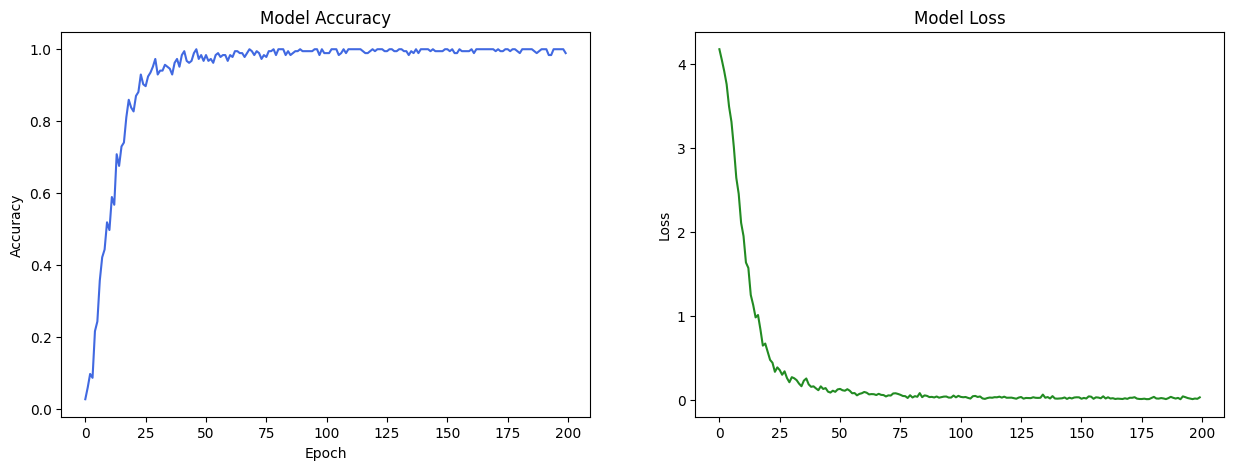

In [15]:
fig, axes = plt.subplots(1, 2, figsize = (15, 5))
axes[0].plot(history.history['accuracy'], color = 'royalblue')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')

axes[1].plot(history.history['loss'], color = 'forestgreen')
axes[1].set_title('Model Loss')
axes[0].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')

plt.show()